In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
df_original_train = pd.read_csv('C:\\Users\\Liu Shi Peng\\Downloads\\titanic\\train.csv')
df_original_test = pd.read_csv('C:\\Users\\Liu Shi Peng\\Downloads\\titanic\\test.csv')
print(df_original_train.shape)
print(df_original_test.shape)

(891, 12)
(418, 11)


In [5]:
df_original_train['data_type'] = 'train'
df_original_test['data_type'] = 'test'
df_original = pd.concat([df_original_train, df_original_test], axis = 0)
df_original.shape

(1309, 13)

In [7]:
df = df_original.copy()

In [17]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,data_type
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


### 1. exploratory data analysis

In [9]:
print(df.dtypes)
df.describe()

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
data_type       object
dtype: object


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [13]:
## missing data
missing_data_count = df.isnull().sum()
print(missing_data_count)

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
data_type         0
dtype: int64


In [15]:
## zero value data
zero_data = df == 0
zero_data.sum()

PassengerId       0
Survived        549
Pclass            0
Name              0
Sex               0
Age               0
SibSp           891
Parch          1002
Ticket            0
Fare             17
Cabin             0
Embarked          0
data_type         0
dtype: int64

In [19]:
# count each ticket group size
df['group_count'] = df.groupby('Ticket')['PassengerId'].transform('count')

In [21]:
# create new features, to mark those solo travller vs group travellers
def is_single(SibSp, Parch, group_count):
    if SibSp==0 and Parch==0 and group_count==1:
        return 1
    else:
        return 0

df['is_single_traveller'] = df.apply(lambda row: is_single(row['SibSp'], row['Parch'], row['group_count']), axis = 1)

In [23]:
# only reserve Ticket info if its group ticket
def group_ticket(Ticket, group_count):
    if group_count > 1:
        return Ticket
    else:
        return 'single_ticket'

df['group_ticket'] = df.apply(lambda row: group_ticket(row['Ticket'], row['group_count']), axis = 1)

In [25]:
df['cabin_class'] = df['Cabin'].str[0].fillna('N')

In [27]:
df['embarked_2'] = df['Embarked'].fillna('S')

In [29]:
df.isna().sum()

PassengerId               0
Survived                418
Pclass                    0
Name                      0
Sex                       0
Age                     263
SibSp                     0
Parch                     0
Ticket                    0
Fare                      1
Cabin                  1014
Embarked                  2
data_type                 0
group_count               0
is_single_traveller       0
group_ticket              0
cabin_class               0
embarked_2                0
dtype: int64

### 1.0 - missing data handling

In [31]:
df_nomissing = df.copy()

In [33]:
df_nomissing['age_2'] = df_nomissing['Age'].fillna(df_nomissing.groupby('group_ticket')['Age'].transform('median')).fillna(30)

In [37]:
df_nomissing['fare_2'] = df_nomissing['Fare'].fillna(df_nomissing['Fare'].mean())

In [39]:
df_nomissing.isna().sum()

PassengerId               0
Survived                418
Pclass                    0
Name                      0
Sex                       0
Age                     263
SibSp                     0
Parch                     0
Ticket                    0
Fare                      1
Cabin                  1014
Embarked                  2
data_type                 0
group_count               0
is_single_traveller       0
group_ticket              0
cabin_class               0
embarked_2                0
age_2                     0
fare_2                    0
dtype: int64

### 1.1 - feature correlation

#### 1.1 - a. correlation among numerical features

<Axes: >

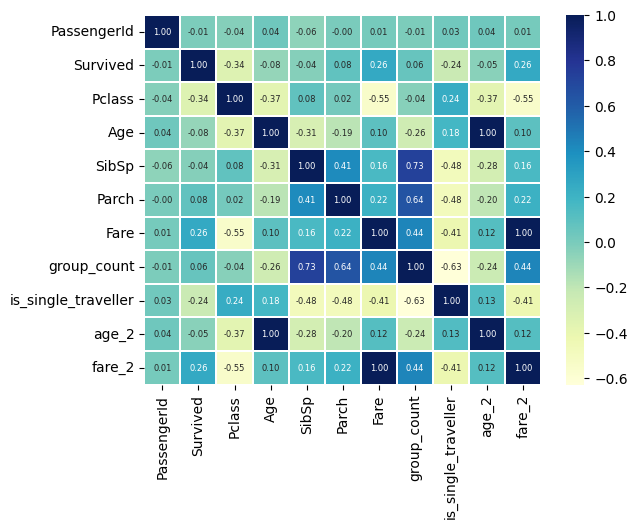

In [43]:
correlation = df_nomissing[df_nomissing['data_type']=='train'].corr(numeric_only=True)
sns.heatmap(correlation,cmap="YlGnBu", annot=True, linewidths=0.2, fmt=".2f", annot_kws={"size": 6} )

#### 1.1 - b. correlation among categorical features

In [45]:
import scipy.stats as stats
def chi_square_test(df):
    cols = df.columns
    results = {}
    print(len(cols))
    p_values = np.zeros((len(cols), len(cols)))
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            # Create a contingency table
            contingency_table = pd.crosstab(df[cols[i]], df[cols[j]])
            # Perform Chi-Square test
            chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
            p_values[i,j] = p
            p_values[j,i] = p

            # Save results
            results[f"{cols[i]} vs {cols[j]}"] = {"p_value": p}
    return p_values.astype('f')

In [47]:
cat_columns = ['Sex', 'Pclass', 'Embarked','group_ticket', 'cabin_class', 'is_single_traveller', 'group_count', 'Survived']

In [49]:
chi_test_df = df_nomissing[cat_columns]

8


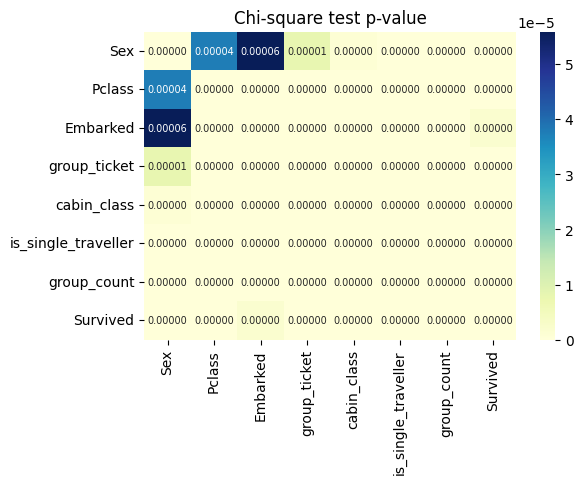

In [51]:
plt.figure(figsize=(6, 4))
sns.heatmap(chi_square_test(chi_test_df), cmap="YlGnBu", annot=True, fmt=".5f", annot_kws={"size": 7}, xticklabels = cat_columns, yticklabels = cat_columns )
plt.title('Chi-square test p-value')
plt.show()

### 1.2 - distribution plot

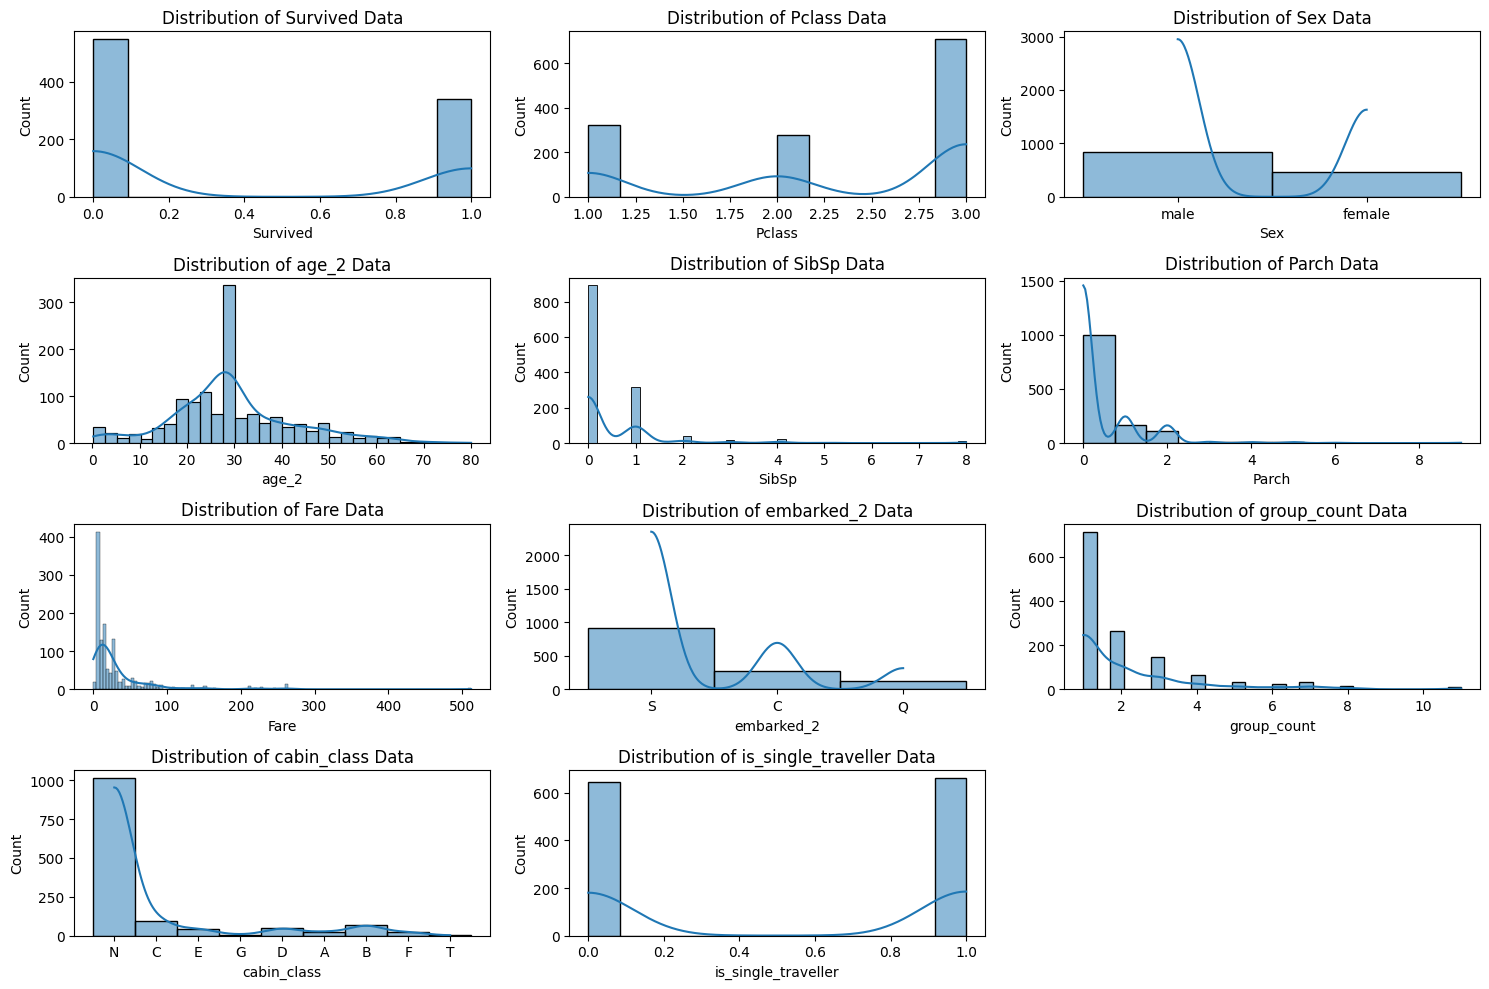

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

num_columns = ['Survived', 'Pclass', 'Sex', 'age_2', 'SibSp','Parch','Fare','embarked_2', 'group_count', 'cabin_class',
       'is_single_traveller']

plt.figure(figsize=(15,10))
for i,col in enumerate(num_columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    # plt.hist(df[col], bins = 20, log = True)
    sns.histplot(df_nomissing[col],kde=True)
    plt.tight_layout()
    plt.plot()

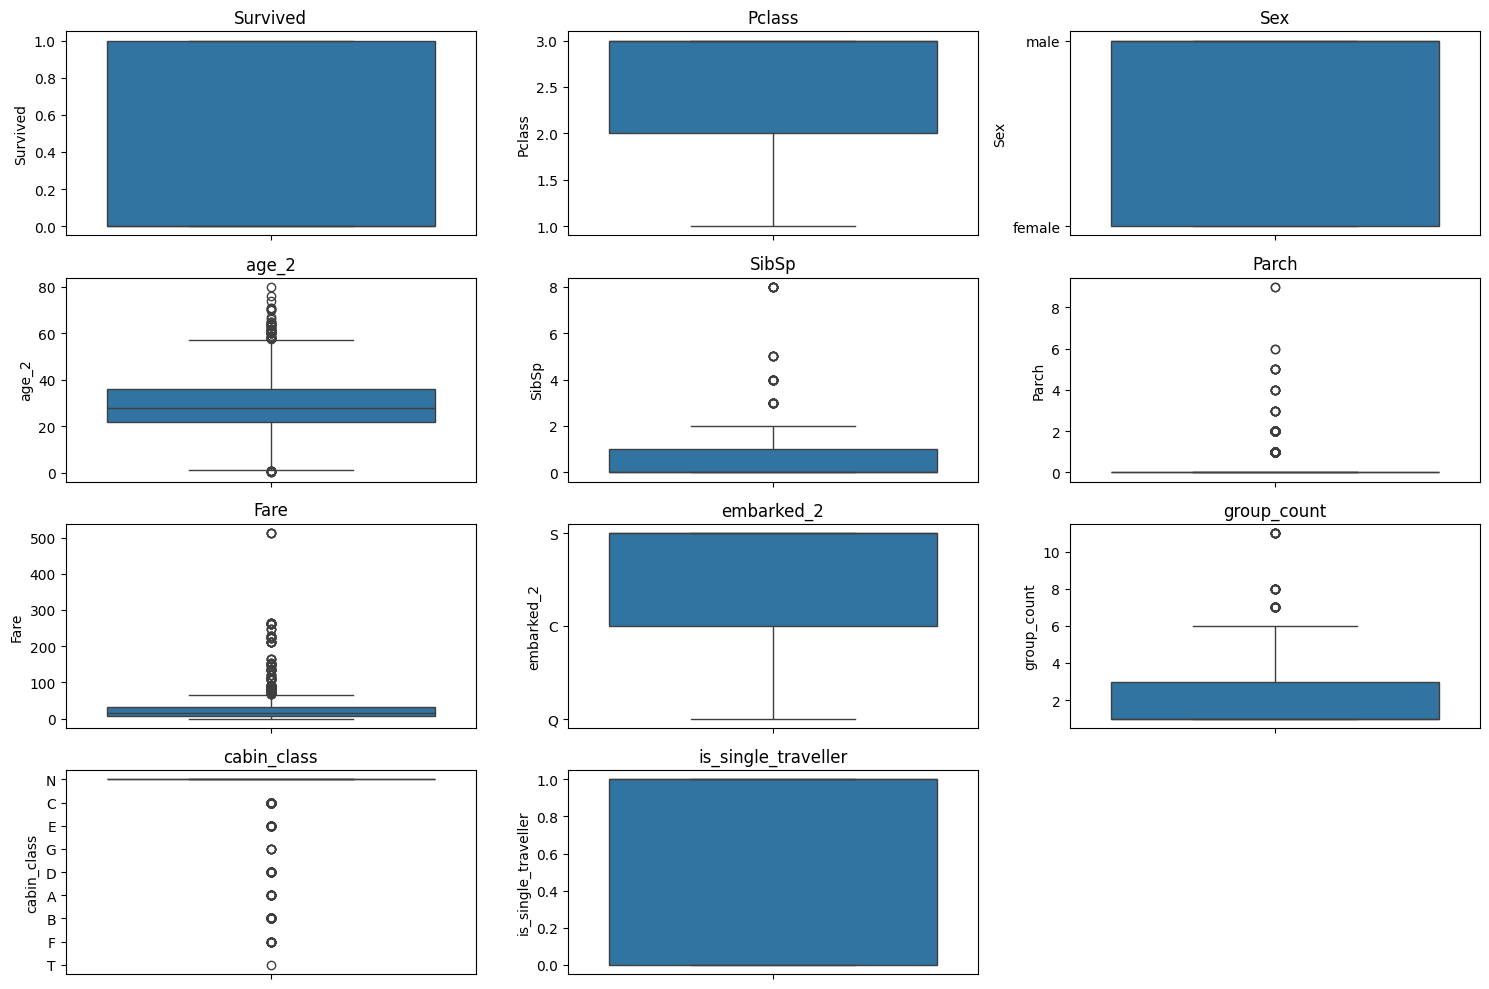

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each column to generate a boxplot
plt.figure(figsize=(15, 10))
for i, column in enumerate(num_columns, 1):
    plt.subplot(4,3,i)
    plt.title(f'{column}')
    sns.boxplot(df_nomissing[column])
plt.tight_layout()
plt.show()

### 1.3 - outlier detection

In [ ]:
df_no_outlier = df_nomissing.copy()

#### 1.3.1 - gaussian error detection

In [ ]:
numeric_col = ['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak','HeartDisease']

In [ ]:
from scipy import stats
z_scores = np.abs(stats.zscore(df_one_hot[numeric_col]))

threshold = 3
# pd.DataFrame(np.where(z_scores > threshold))
df_error = z_scores > threshold
# df1_error.sum()
df_error['sum_error'] = df_error.sum(axis = 1)
error_index = df_error[df_error['sum_error']>=1].index
error_index

#### 1.3.2 - isolation forest detection

In [ ]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(df_one_hot)
error_index_if  = np.where(outliers==-1)[0]
# -1 indicates an outlier
# df_no_outlier['outlier'] = outliers
# error_index_if = df_no_outlier[df_no_outlier['outlier'] == -1].index
error_index_if 

In [ ]:
df_no_outlier = df_one_hot[~df_one_hot.index.isin(error_index )]
df_no_outlier.shape

### 1.4 - on hot encoding

In [74]:
df_one_hot = df_nomissing.copy()
df_one_hot.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'data_type',
       'group_count', 'is_single_traveller', 'group_ticket', 'cabin_class',
       'embarked_2', 'age_2', 'fare_2'],
      dtype='object')

In [76]:
features_selection = ['Survived', 'Pclass', 'Sex',  'SibSp',
       'Parch', 'fare_2', 'embarked_2', 'group_count', 'data_type',
       'is_single_traveller', 'age_2']

In [78]:
cat_columns = ['Sex', 'Pclass', 'embarked_2']
df_one_hot = pd.get_dummies(df_one_hot[features_selection], columns = cat_columns, dtype=float)
df_one_hot.shape

(1309, 16)

In [80]:
df_one_hot.head()

,Survived,SibSp,Parch,fare_2,group_count,data_type,is_single_traveller,age_2,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,embarked_2_C,embarked_2_Q,embarked_2_S
0,0.0,1,0,7.2500,1,train,0,22.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,1,0,71.2833,2,train,0,38.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0,0,7.9250,1,train,1,26.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,1,0,53.1000,2,train,0,35.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0,0,8.0500,1,train,1,35.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


## 2. Modelling

In [82]:
dfm = df_one_hot[df_one_hot['data_type'] == 'train']
dft = df_one_hot[df_one_hot['data_type'] == 'test']

In [225]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score

In [86]:
features = [x for x in dfm.columns if x not in ('Survived', 'data_type')]
len(features)

14

In [88]:
X = dfm[features]
y = dfm['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 41)
print('train shape', X_train.shape)
print('test shape', X_test.shape)

train shape (623, 14)
test shape (268, 14)


### Decision Tree

In [120]:
# # try to get a sense of the parameters without grid search
# for min_leaf in range(1,30,2):
#     for min_split in range(2, 30, 2): 
#         model = DecisionTreeClassifier(min_samples_split = min_split, min_samples_leaf = min_leaf).fit(X_train, y_train)
#         pred_train = model.predict(X_train)
#         pred_test = model.predict(X_test)
#         accuracy_train = accuracy_score(pred_train, y_train)
#         accuracy_test = accuracy_score(pred_test, y_test)
#         print('min_leaf:', min_leaf, 'min_split:', min_split, 'accuracy:',(f'{accuracy_train:.2f}', f'{accuracy_test:.2f}'))

In [237]:
# cross validation: YES
# grid search: NO
for min_leaf in range(1,30,2):
    for min_split in range(2, 30, 2): 
        dt_model = DecisionTreeClassifier(min_samples_split = min_split, min_samples_leaf = min_leaf)
        kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
        cv_results = cross_validate(dt_model, X, y, cv=kf, return_train_score=True, scoring='accuracy')
        
        print('min_leaf:', min_leaf, 'min_split:', min_split, 'accuracy:',(f'{cv_results['train_score'].mean():.2f}', f'{cv_results['test_score'].mean():.2f}'))

min_leaf: 1 min_split: 2 accuracy: ('0.98', '0.77')
min_leaf: 1 min_split: 4 accuracy: ('0.95', '0.79')
min_leaf: 1 min_split: 6 accuracy: ('0.94', '0.80')
min_leaf: 1 min_split: 8 accuracy: ('0.93', '0.79')
min_leaf: 1 min_split: 10 accuracy: ('0.91', '0.80')
min_leaf: 1 min_split: 12 accuracy: ('0.91', '0.81')
min_leaf: 1 min_split: 14 accuracy: ('0.90', '0.82')
min_leaf: 1 min_split: 16 accuracy: ('0.89', '0.82')
min_leaf: 1 min_split: 18 accuracy: ('0.89', '0.82')
min_leaf: 1 min_split: 20 accuracy: ('0.89', '0.82')
min_leaf: 1 min_split: 22 accuracy: ('0.88', '0.82')
min_leaf: 1 min_split: 24 accuracy: ('0.88', '0.82')
min_leaf: 1 min_split: 26 accuracy: ('0.88', '0.82')
min_leaf: 1 min_split: 28 accuracy: ('0.87', '0.82')
min_leaf: 3 min_split: 2 accuracy: ('0.91', '0.80')
min_leaf: 3 min_split: 4 accuracy: ('0.91', '0.80')
min_leaf: 3 min_split: 6 accuracy: ('0.91', '0.80')
min_leaf: 3 min_split: 8 accuracy: ('0.90', '0.81')
min_leaf: 3 min_split: 10 accuracy: ('0.90', '0.82')
m

In [130]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree model
dt = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    # 'splitter': ['best', 'random'],    # Strategy used to choose the split at each node
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the tree
    'min_samples_split': np.arange(2,30, 2),   # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1,10),     # Minimum number of samples required to be at a leaf node
    #'max_features': [None, 'auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)
best_model_dt = grid_search_dt.best_estimator_
# Print the best parameters and the best score
print(f"Best parameters found: {grid_search_dt.best_params_}")

pred_train = best_model_dt.predict(X_train)
pred_test = best_model_dt.predict(X_test)
accuracy_train = accuracy_score(pred_train, y_train)
accuracy_test = accuracy_score(pred_test, y_test)
print('Accuracy', (f'{accuracy_train:.4f}', f'{accuracy_test:.4f}'))

Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 18}
Accuracy ('0.8652', '0.8433')


In [241]:

dt_model = DecisionTreeClassifier(max_depth = 10, min_samples_split = 9, min_samples_leaf = 10)
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
cv_scores_dt = cross_validate(dt_model, X, y, cv=kf, return_train_score=True, scoring='accuracy')

print('accuracy:',(f'{cv_scores_dt['train_score'].mean():.2f}', f'{cv_scores_dt['test_score'].mean():.2f}'))

accuracy: ('0.86', '0.82')


In [233]:
cv_scores_dt

{'fit_time': array([0.0085001 , 0.00699925, 0.0059979 , 0.00700331, 0.00699973]),
 'score_time': array([0.00413179, 0.00503707, 0.00452137, 0.0039978 , 0.00500059]),
 'test_score': array([0.82681564, 0.81460674, 0.87640449, 0.80898876, 0.80337079]),
 'train_score': array([0.85393258, 0.86115007, 0.8569425 , 0.88078541, 0.85974755])}

In [138]:
# pd.DataFrame(grid_search_dt.cv_results_).sort_values(by = ['rank_test_score']).head(20)

In [ ]:
# feature_importance = best_model_dt.feature_importances_
# feature_importance_df = pd.DataFrame({'fatures': X.columns, 'importance':best_model_dt.feature_importances_})
# feature_importance_df.sort_values(by = 'importance', ascending = False)

### Random Forecast

In [150]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': [10, 20, 30],   # Maximum depth of the tree
    'min_samples_split': np.arange(2,20, 2),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 10, 2),  # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs = -1, scoring='accuracy')

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search_rf.best_params_}")

# Evaluate the best model on the test set
best_model_rf = grid_search_rf.best_estimator_
pred_train = best_model_rf.predict(X_train)
pred_test = best_model_rf.predict(X_test)
accuracy_train = accuracy_score(pred_train, y_train)
accuracy_test = accuracy_score(pred_test, y_test)
print('Accuracy', (f'{accuracy_train:.4f}', f'{accuracy_test:.4f}'))

Best parameters found: {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 100}
Accuracy ('0.8828', '0.8321')


In [229]:
rf_model = RandomForestClassifier(n_estimators = 100, max_depth = 5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
cv_scores_rf = cross_validate(rf_model, X, y, cv=kf, return_train_score=True, scoring='accuracy')
print('accuracy:',(f'{cv_scores_rf['train_score'].mean():.2f}', f'{cv_scores_rf['test_score'].mean():.2f}'))

accuracy: ('0.85', '0.82')


In [231]:
cv_scores_rf

{'fit_time': array([0.34623885, 0.30670452, 0.27074885, 0.55078053, 0.2864542 ]),
 'score_time': array([0.01203942, 0.01103067, 0.0131073 , 0.02075481, 0.01150656]),
 'test_score': array([0.79888268, 0.80898876, 0.87640449, 0.79775281, 0.83707865]),
 'train_score': array([0.85393258, 0.85834502, 0.8345021 , 0.84712482, 0.84291725])}

### XGB model

In [186]:
from xgboost import XGBClassifier
import xgboost as xgb

# n = int(len(X_train)*0.8)
# X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

xgb_model = XGBClassifier(n_estimators = 100, learning_rate = 0.03, gamma = 0.1, max_depth = 5)
xgb_model.fit(X_train,y_train) #, eval_set = [(X_train_eval,y_train_eval)]

pred_train = xgb_model.predict(X_train)
pred_test = xgb_model.predict(X_test)

accuracy_train = accuracy_score(pred_train, y_train)
accuracy_test = accuracy_score(pred_test, y_test)
print('Accuracy', (f'{accuracy_train:.4f}', f'{accuracy_test:.4f}'))

Accuracy ('0.8732', '0.8433')


In [247]:
xgb_model = XGBClassifier(n_estimators = 100, learning_rate = 0.03, gamma = 0.1, max_depth = 6)
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
cv_scores_xgb = cross_validate(xgb_model, X, y, cv=kf, return_train_score=True, scoring='accuracy')
print('accuracy:',(f'{cv_scores_xgb['train_score'].mean():.2f}', f'{cv_scores_xgb['test_score'].mean():.2f}'))
cv_scores_xgb

accuracy: ('0.89', '0.84')


{'fit_time': array([0.46058536, 0.2198019 , 0.37560725, 0.27472138, 0.2586062 ]),
 'score_time': array([0.01499987, 0.01681209, 0.01546288, 0.01413846, 0.01270127]),
 'test_score': array([0.81005587, 0.83146067, 0.89325843, 0.80898876, 0.85955056]),
 'train_score': array([0.89044944, 0.89200561, 0.88779804, 0.89901823, 0.88078541])}

In [ ]:
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 500],
    'max_depth': [3,5, 7], 
    'gamma': [0, 0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2]
}

param_grid = {
    'max_depth': [3, 5,7,9],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [500],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2]
}

xgb_model = XGBClassifier()

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=params, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)
# Print the best parameters and the best score
print(f"Best parameters found: {grid_search_xgb.best_params_}")

# Evaluate the best model on the test set
best_model_xgb = grid_search_xgb.best_estimator_
pred_train = best_model_xgb.predict(X_train)
pred_test = best_model_xgb.predict(X_test)
accuracy_train = accuracy_score(pred_train, y_train)
accuracy_test = accuracy_score(pred_test, y_test)
print('Accuracy', (f'{accuracy_train:.4f}', f'{accuracy_test:.4f}'))

### Logistic Regression

In [210]:
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(random_state=0).fit(X_train_scaled , y_train)

pred_train = lr.predict(X_train_scaled)
pred_test = lr.predict(X_test_scaled)
accuracy_train = accuracy_score(pred_train, y_train)
accuracy_test = accuracy_score(pred_test, y_test)
print('Accuracy', (f'{accuracy_train:.4f}', f'{accuracy_test:.4f}'))

Accuracy ('0.8074', '0.8172')


### SVC

In [263]:
from sklearn.svm import SVC
# svc = SVC(kernel='rbf', C=100.0, random_state=42)
svc = SVC()
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'kernel': ['linear', 'rbf']  # Specifies the kernel type
}

# Step 7: Initialize GridSearchCV
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search_svc.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_search_svc.best_params_}")

best_svc = grid_search_svc.best_estimator_
y_pred = best_svc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.8358


In [265]:
svc = SVC(C = 5, gamma = 0.01, kernel = 'rbf')
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
cv_scores_svc = cross_validate(svc, scaler.fit_transform(X), y, cv=kf, return_train_score=True, scoring='accuracy')

print('accuracy:',(f'{cv_scores_svc['train_score'].mean():.2f}', f'{cv_scores_svc['test_score'].mean():.2f}'))
cv_scores_svc

accuracy: ('0.82', '0.81')


{'fit_time': array([0.033885  , 0.02201867, 0.03673911, 0.02299809, 0.02403474]),
 'score_time': array([0.01452327, 0.01361489, 0.01401711, 0.01203942, 0.01000285]),
 'test_score': array([0.80446927, 0.79775281, 0.85955056, 0.78089888, 0.80898876]),
 'train_score': array([0.81741573, 0.82187938, 0.80084151, 0.82328191, 0.81907433])}

### Naive Bayers Classifier

In [212]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = GaussianNB()
# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7948


### K-NN classifer

In [214]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
k_values = range(1, 31)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the value of k that gives the highest cross-validation score
best_k = k_values[np.argmax(cv_scores)]
print(f'Best value of k: {best_k}')

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Best value of k: 5
Accuracy: 0.7127


### Stack Ensembling Model

In [ ]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
def stacking_ensemble_classification(X_train, y_train, X_test, y_test, base_models, meta_model, n_splits=5, random_state=42):
    """
    Implements a stacking ensemble model for classification.
    Parameters:
    X: Features (numpy array or pandas DataFrame)
    y: Target variable (numpy array or pandas Series)
    base_models: A list of instantiated base models (e.g., [model1, model2, model3])
    meta_model: The meta-learner model (e.g., LogisticRegression())
    n_splits: Number of splits for cross-validation (default is 5)
    random_state: Random state for reproducibility (default is 42)
    
    Returns:
    Trained meta model and accuracy on test data.
    """
    # Split data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
    
    # Set up cross-validation to create out-of-fold predictions
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Create an empty array to store the out-of-fold predictions for base models
    base_predictions_train = np.zeros((X_train.shape[0], len(base_models)))
    base_predictions_test = np.zeros((X_test.shape[0], len(base_models)))
    
    for i, model in enumerate(base_models):
        model_predictions_test = np.zeros((X_test.shape[0], n_splits))  # To store the test predictions over CV folds
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            # Clone the model to avoid using the same instance multiple times
            model_cloned = clone(model)
            
            # Train on the current fold
            print(type(X_train))
            print(type(y_train))
            model_cloned.fit(X_train.iloc[train_idx], y_train[train_idx])
            
            # Predict on the validation fold and the test set
            base_predictions_train[val_idx, i] = model_cloned.predict(X_train.iloc[val_idx])
            model_predictions_test[:, fold] = model_cloned.predict(X_test)
        
        # Take the mean of the test predictions over the folds
        base_predictions_test[:, i] = model_predictions_test.mean(axis=1)
    
    # Train the meta-learner on the base models' out-of-fold predictions
    meta_model.fit(base_predictions_train, y_train)
    
    # Make predictions with the meta-learner
    meta_predictions = meta_model.predict(base_predictions_test)
    
    # Evaluate the stacking ensemble model
    accuracy = accuracy_score(y_test, meta_predictions)
    print(f'Stacking Ensemble Accuracy: {accuracy:.4f}')
    
    return meta_model, accuracy


In [ ]:
base_models = [RandomForestClassifier(n_estimators=100, random_state=42),
                   GradientBoostingClassifier(n_estimators=100, random_state=42),
                   DecisionTreeClassifier(),
                   SVC(),
                   LogisticRegression(max_iter=1000)
              ]
meta_model = LogisticRegression(max_iter=10000)

trained_meta_model, accuracy = stacking_ensemble_classification(pd.DataFrame(X_train_scaled), y_train, pd.DataFrame(X_test_scaled), y_test, base_models, meta_model)

## 3. Prediction: on test data

In [267]:
dft.shape

(418, 16)

In [269]:
dft.head()

,Survived,SibSp,Parch,fare_2,group_count,data_type,is_single_traveller,age_2,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,embarked_2_C,embarked_2_Q,embarked_2_S
0,NaN,0,0,7.8292,1,test,1,34.5,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,NaN,1,0,7.0000,1,test,0,47.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,NaN,0,0,9.6875,1,test,1,62.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,NaN,0,0,8.6625,1,test,1,27.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,NaN,1,1,12.2875,2,test,0,22.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [271]:
X_to_predict = dft[features]

In [273]:
X_to_predict.head()

,SibSp,Parch,fare_2,group_count,is_single_traveller,age_2,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,embarked_2_C,embarked_2_Q,embarked_2_S
0,0,0,7.8292,1,1,34.5,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,0,7.0000,1,0,47.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0,0,9.6875,1,1,62.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0,8.6625,1,1,27.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,1,12.2875,2,0,22.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
xgb_model.fit(X, y)
xgb_predict = xgb_model.predict(X_to_predict)

In [281]:
dt_model.fit(X, y)
dt_predict = dt_model.predict(X_to_predict)

In [283]:
rf_model.fit(X, y)
rf_predict = rf_model.predict(X_to_predict)

In [ ]:
lr_predict = lr.predict(scaler.fit_transform(X_to_predict))

In [285]:
final_predict = pd.DataFrame({'xgb':xgb_predict, 'dt': dt_predict, 'rf': rf_predict})
final_predict['vote'] = final_predict.apply(lambda row: row.mode()[0], axis=1)
final_predict.to_csv('C:\\Users\\Liu Shi Peng\\Downloads\\titanic\\prediction_2.csv')